<a href="https://colab.research.google.com/github/himavanth508/Predicting_Song_Genres_from_Audio_Features/blob/main/Predicting_Song_Genres_from_Audio_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
tracks = pd.read_csv('fma-rock-vs-hiphop.csv')
music_features = pd.read_json('echonest-metrics.json',precise_float=True)

In [ ]:
tracks.head()

,track_id,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,...,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
0,135,256000,1,NaN,2008-11-26 01:43:26,2008-11-26 00:00:00,837,0,Rock,"[45, 58]",...,NaN,2484,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1832,NaN,0,NaN,[],Father's Day
1,136,256000,1,NaN,2008-11-26 01:43:35,2008-11-26 00:00:00,509,0,Rock,"[45, 58]",...,NaN,1948,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1498,NaN,0,NaN,[],Peel Back The Mountain Sky
2,151,192000,0,NaN,2008-11-26 01:44:55,NaN,192,0,Rock,[25],...,NaN,701,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,148,NaN,4,NaN,[],Untitled 04
3,152,192000,0,NaN,2008-11-26 01:44:58,NaN,193,0,Rock,[25],...,NaN,637,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,98,NaN,11,NaN,[],Untitled 11
4,153,256000,0,Arc and Sender,2008-11-26 01:45:00,2008-11-26 00:00:00,405,5,Rock,[26],...,NaN,354,en,Attribution-NonCommercial-NoDerivatives (aka M...,424,NaN,2,NaN,[],Hundred-Year Flood


In [ ]:
music_features.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072


Now we are going to merge these two datasets keeping only the relevant columns

In [ ]:
audio_data=music_features.merge(tracks[['genre_top', 'track_id']], on='track_id')

In [ ]:
audio_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,Hip-Hop
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,Hip-Hop
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,Hip-Hop
3,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,Hip-Hop
4,153,0.988306,0.255661,0.979774,0.973006,0.121342,0.051740,90.241,0.034018,Rock


In [ ]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 375.3+ KB


## Feature Reduction

In [ ]:
# As genre_top contains string values
temp=audio_data.drop(['genre_top'],axis=1)
correlations = temp.corr()
correlations.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


No pair of features have a strong enough correlation that we can eliminate a feature. Hence, lets now use the PCA approach.

## PCA Approach

In [ ]:
features = audio_data.drop(['genre_top','track_id'],axis=1)
labels = audio_data['genre_top']

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
pca = PCA()
pca.fit(scaled_features)
exp_variance = pca.explained_variance_ratio_
num_components = pca.n_components_

Text(0.5, 0, 'Principal Component #')

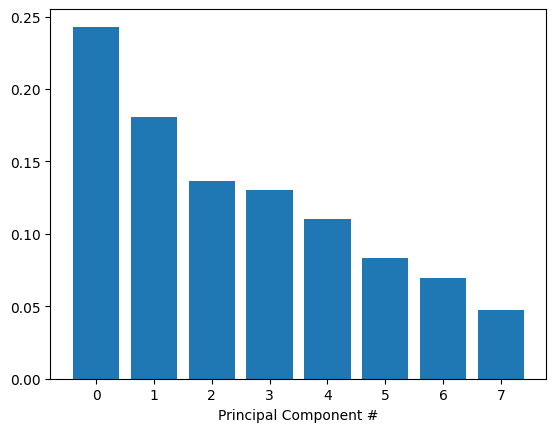

In [ ]:
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(num_components), exp_variance)
ax.set_xlabel('Principal Component #')

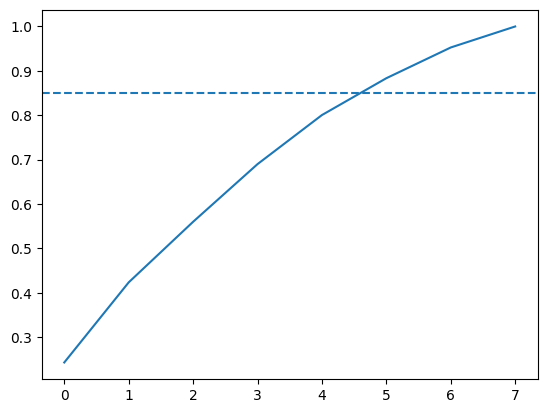

In [ ]:
cum_exp_variance = np.cumsum(exp_variance) #calculate the cumulative explained variance

fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--') # for considering features needed to explain 85% of the variance

From the figure, I can say about 5 features are needed to explain 85% of the variance, hence this is the number of features I will use to carry out the model training with.

In [ ]:
n_components=5

In [ ]:
pca = PCA(n_components, random_state=10)
pca.fit(scaled_features)
pca_projection = pca.transform(scaled_features)

In [ ]:
pca_projection.shape

(4802, 5)

## Decision Tree Classifier Model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_projection,labels,random_state=10)

In [ ]:
model_dt = DecisionTreeClassifier(random_state=10)
model_dt.fit(X_train,y_train)

DecisionTreeClassifier(random_state=10)

In [ ]:
predictions_dt = model_dt.predict(X_test)
print("Decision Tree Classifier:", model_dt.score(X_test,y_test))

Decision Tree Classifier: 0.8426311407160699


## Logistic Regression Model

In [ ]:
model_lg = LogisticRegression(random_state=10)
model_lg.fit(X_train,y_train)

LogisticRegression(random_state=10)

In [ ]:
predictions_lg = model_lg.predict(X_test)
print("Logistic Regression:", model_lg.score(X_test,y_test))

Logistic Regression: 0.8767693588676103


## KNN Model

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred_knn = knn.predict(X_test)

## Naive Bayes Model

In [ ]:
classifier = GaussianNB()

In [ ]:
classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred_Naive=classifier.predict(X_test)

## SVM Model

In [ ]:
clf = SVC()

In [ ]:
clf.fit(X_train, y_train)

SVC()

In [ ]:
y_pred_svc = clf.predict(X_test)

## XGBoost Model

In [ ]:
clf_1 = xgb.XGBClassifier()

In [ ]:
y_train_1 = y_train.replace({'Hip-Hop': 0, 'Rock': 1})
y_test_1 = y_test.replace({'Hip-Hop': 0, 'Rock': 1})

In [ ]:
clf_1.fit(X_train, y_train_1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_xgb = clf_1.predict(X_test)

## Determing the best model

In [ ]:
report_dt = classification_report(y_test,predictions_dt)
report_lg = classification_report(y_test,predictions_lg)
report_kn = classification_report(y_test,y_pred_knn)
report_nb = classification_report(y_test,y_pred_Naive)
report_svc = classification_report(y_test,y_pred_svc)
report_xgb = classification_report(y_test_1,y_pred_xgb)

print("Decision Tree Classifier: \n", report_dt)
print("Logistic Regression: \n", report_lg)
print("K-Nearest Neighbours: \n", report_kn)
print("Naive Bayes: \n", report_nb)
print("Support Vector Machine: \n", report_svc)
print("XGBoost: \n", report_xgb)

Decision Tree Classifier: 
               precision    recall  f1-score   support

     Hip-Hop       0.59      0.63      0.61       235
        Rock       0.91      0.89      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.76      0.76      1201
weighted avg       0.85      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.55      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201

K-Nearest Neighbours: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.63      0.71       235
        Rock       0.92      0.96      0.94       966

    accuracy                           0.90      1201
   macro avg       0.86      0.80      0.82      1201

<Axes: xlabel='count', ylabel='genre_top'>

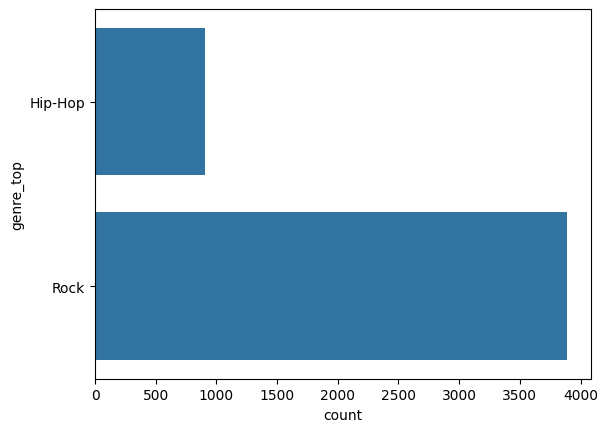

In [ ]:
sns.countplot(audio_data['genre_top'], label = "Count")

In [ ]:
hip_hop = audio_data.loc[audio_data['genre_top'] == 'Hip-Hop']
rock = audio_data.loc[audio_data['genre_top'] == 'Rock']

In [ ]:
hip_hop.shape

(910, 10)

In [ ]:
rock.shape

(3892, 10)

## Resampling datset

In [ ]:
rock = rock.sample(hip_hop.shape[0], random_state=10)

In [ ]:
balanced_data = pd.concat([rock, hip_hop])

In [ ]:
balanced_data.head()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,genre_top
773,4038,0.825838,0.263645,0.797948,0.842318,0.177089,0.045277,166.580,0.713586,Rock
2273,19501,0.966635,0.386114,0.651980,0.869472,0.353138,0.032208,130.767,0.712374,Rock
2846,31252,0.721510,0.358035,0.948187,0.801184,0.105706,0.095522,125.884,0.208728,Rock
2147,17947,0.617370,0.487321,0.918848,0.817050,0.089908,0.040337,129.565,0.268893,Rock
2654,27421,0.025464,0.245523,0.422381,0.938011,0.441009,0.038795,149.960,0.439876,Rock


In [ ]:
features = balanced_data.drop(['genre_top', 'track_id'], axis=1)
labels = balanced_data['genre_top']

In [ ]:
pca_projection = pca.fit_transform(scaler.fit_transform(features))
pca_projection.shape

(1820, 5)

## Updated Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pca_projection, labels, random_state=10)

In [ ]:
y_train_1 = y_train.replace({'Hip-Hop': 0, 'Rock': 1})
y_test_1 = y_test.replace({'Hip-Hop': 0, 'Rock': 1})

In [ ]:
model_dt = DecisionTreeClassifier(random_state=10)
model_dt.fit(X_train,y_train)
predictions_dt = model_dt.predict(X_test)

In [ ]:
model_lr = LogisticRegression(random_state=10)
model_lr.fit(X_train,y_train)
predictions_lr = model_lr.predict(X_test)

In [ ]:
model_svc = SVC(random_state=10)
model_svc.fit(X_train,y_train)
predictions_svc = model_svc.predict(X_test)

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)
predictions_knn = model_knn.predict(X_test)

In [ ]:
model_nb = GaussianNB()
model_nb.fit(X_train, y_train)
predictions_nb = model_nb.predict(X_test)

In [ ]:
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train_1)
predictions_xgb = model_xgb.predict(X_test)

In [ ]:
print("Decision Tree: \n", classification_report(y_test, predictions_dt))
print("Logistic Regression: \n", classification_report(y_test, predictions_lr))
print("K-Nearest Neighbours: \n", classification_report(y_test, predictions_knn))
print("Naive Bayes: \n", classification_report(y_test, predictions_nb))
print("Support Vector Machine: \n", classification_report(y_test, predictions_svc))
print("XGBoost: \n", classification_report(y_test_1, predictions_xgb))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.75      0.77      0.76       230
        Rock       0.76      0.74      0.75       225

    accuracy                           0.75       455
   macro avg       0.75      0.75      0.75       455
weighted avg       0.75      0.75      0.75       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.78      0.81       230
        Rock       0.79      0.84      0.82       225

    accuracy                           0.81       455
   macro avg       0.81      0.81      0.81       455
weighted avg       0.81      0.81      0.81       455

K-Nearest Neighbours: 
               precision    recall  f1-score   support

     Hip-Hop       0.88      0.83      0.85       230
        Rock       0.83      0.89      0.86       225

    accuracy                           0.86       455
   macro avg       0.86      0.86      0.86       455
weighted a

In [ ]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [ ]:
scores = cross_val_score(model_dt, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print("Decision Tree Classifier Accuracy:", np.mean((scores)))

Decision Tree Classifier Accuracy: 0.771304347826087


In [ ]:
scores = cross_val_score(model_lg, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print("Logistic Regression Accuracy:", np.mean((scores)))

Logistic Regression Accuracy: 0.8070531400966183


In [ ]:
scores = cross_val_score(model_svc, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print("Support Vector Machine Accuracy:", np.mean((scores)))

Support Vector Machine Accuracy: 0.8419806763285024


In [ ]:
scores = cross_val_score(model_knn, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print("K-Nearest Neighbours Accuracy:", np.mean((scores)))

K-Nearest Neighbours Accuracy: 0.8265217391304347


In [ ]:
scores = cross_val_score(model_nb, X_test,y_test, scoring='accuracy', cv=cv, n_jobs=-1)
print("Naive Bayes Accuracy:", np.mean((scores)))

Naive Bayes Accuracy: 0.8399033816425122


In [ ]:
scores = cross_val_score(model_xgb, X_test,y_test_1, scoring='accuracy', cv=cv, n_jobs=-1)
print("XGBoost Accuracy:", np.mean((scores)))

XGBoost Accuracy: 0.8288888888888888


Support vector machine model was able to classify with the highest accuracy